# Logistic Regression on Amazon Reviews

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix

C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load and Sample data

In [2]:
#Data here used is preprocessed(deduplication,removal of html tags,punctuation,stop words,stemming)
con =sqlite3.connect(r'C:\Users\Friend\AI\AI_datasets\Amazon\cleaned_database.sqlite')
filtered_data  = pd.read_sql_query('SELECT * FROM Reviews WHERE Score != 3',con)
filtered_data = filtered_data.drop('index',axis = 1)
filtered_data['Score'] = filtered_data['Score'].map(lambda x: 1 if x == 'positive' else 0)
filtered_data = filtered_data.sort_values('Time')

In [3]:
data = filtered_data.head(100000)
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [4]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data['CleanedText'], data['Score'], test_size=0.3, random_state=0)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(70000,) (70000,) (30000,) (30000,)


# Converting words to vectors(BOW,TFIDF,Average Word2Vec,TFIDF Weighted Word2Vec )

* BOW

In [6]:
# Performing BOW on review
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
vocabulary = count_vect.fit(X_train)

In [7]:
bag_of_words_train = count_vect.transform(X_train)
print(bag_of_words_train.shape)

(70000, 31572)


In [8]:
bag_of_words_test = count_vect.transform(X_test)
print(bag_of_words_test.shape)

(30000, 31572)


* TFIDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocabulary = tf_idf_vect.fit(X_train)

In [6]:
tf_idf_train = tf_idf_vect.transform(X_train)
print(tf_idf_train.shape)

(70000, 932590)


In [7]:
tf_idf_test = tf_idf_vect.transform(X_test)
print(tf_idf_test.shape)

(30000, 932590)


* Average Word2Vec

In [18]:
from gensim.models import Word2Vec

list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())

#word2vec
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#Average word2vec
sent_vectors_train = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

C:\Users\Friend\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [19]:
from gensim.models import Word2Vec

i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())

#Average word2vec
sent_vectors_test = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

* Tf_Idf Weighted word2Vector

In [22]:
from gensim.models import Word2Vec

i=0
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())

#get tf_idf feature names
tfidf_feat = tf_idf_vect.get_feature_names()

#word2vec
w2v_model =Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

#tfidf wieghted vector
tfidf_sent_vectors_train = [];
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]            
            tf_idf = tf_idf_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        else:
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [ ]:
import gensim

i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())

#get tf_idf
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; 

#tfidf wieghted vector
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]            
            tf_idf = tf_idf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        else:
            continue
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

# Grid Search using L1 regularization

In [9]:
grid_hyperparameter = [{'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}]
print(grid_hyperparameter)

[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}]


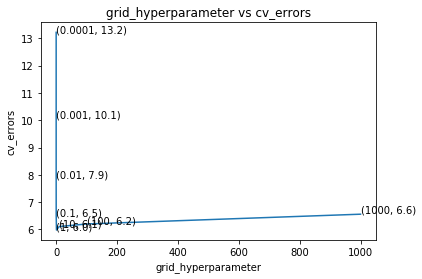

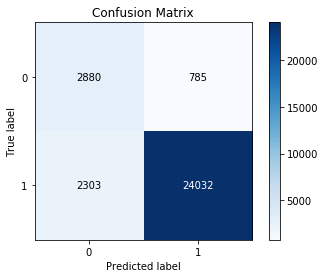

In [10]:
#train model
bow_grid_model = GridSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), grid_hyperparameter, scoring = 'f1', cv=3)
bow_grid_model.fit(bag_of_words_train, y_train)

#plot cv errors
bow_grid_cv_errors = [(1-x[1])*100 for x in bow_grid_model.grid_scores_]
plt.plot(grid_hyperparameter[0]['C'],bow_grid_cv_errors)
for xy in zip(grid_hyperparameter[0]['C'],np.round(bow_grid_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('grid_hyperparameter')
plt.ylabel('cv_errors')
plt.title('grid_hyperparameter vs cv_errors')
plt.show()

#Best C value
bow_grid_c = bow_grid_model.best_estimator_.get_params()['C']

#f1 score
bow_grid_f1_train = bow_grid_model.score(bag_of_words_train, y_train)
bow_grid_f1_test = bow_grid_model.score(bag_of_words_test, y_test)

#predict values
pred = bow_grid_model.predict(bag_of_words_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

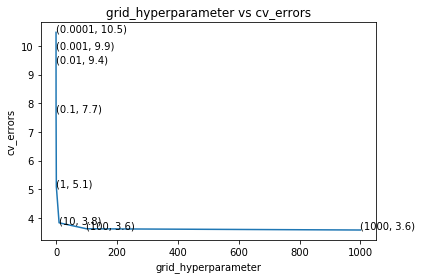

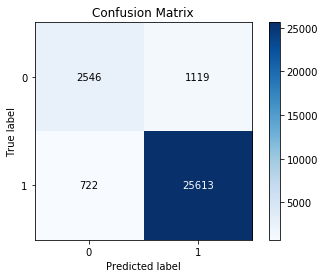

In [17]:
#train model
tfidf_grid_model = GridSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), grid_hyperparameter, scoring = 'f1', cv=5)
tfidf_grid_model.fit(tf_idf_train, y_train)

#plot cv errors
tfidf_grid_cv_errors = [(1-x[1])*100 for x in tfidf_grid_model.grid_scores_]
plt.plot(grid_hyperparameter[0]['C'],tfidf_grid_cv_errors)
for xy in zip(grid_hyperparameter[0]['C'],np.round(tfidf_grid_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('grid_hyperparameter')
plt.ylabel('cv_errors')
plt.title('grid_hyperparameter vs cv_errors')
plt.show()

#Best c value
tfidf_grid_c = tfidf_grid_model.best_estimator_.get_params()['C']

#f1 score
tfidf_grid_f1_train = tfidf_grid_model.score(tf_idf_train, y_train)
tfidf_grid_f1_test = tfidf_grid_model.score(tf_idf_test, y_test)

#confusion matrix
pred = tfidf_grid_model.predict(tf_idf_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

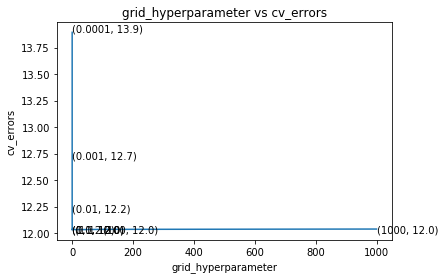

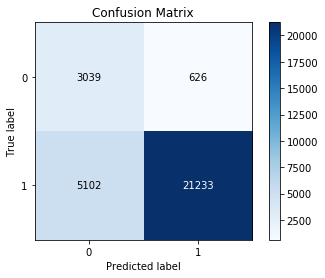

In [20]:
#train model
avgw2vec_grid_model = GridSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), grid_hyperparameter, scoring = 'f1', cv=5)
avgw2vec_grid_model.fit(sent_vectors_train, y_train)

#plot cv errors
avgw2vec_grid_cv_errors = [(1-x[1])*100 for x in avgw2vec_grid_model.grid_scores_]
plt.plot(grid_hyperparameter[0]['C'],avgw2vec_grid_cv_errors)
for xy in zip(grid_hyperparameter[0]['C'],np.round(avgw2vec_grid_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('grid_hyperparameter')
plt.ylabel('cv_errors')
plt.title('grid_hyperparameter vs cv_errors')
plt.show()

#Best c value
avgw2vec_grid_c = avgw2vec_grid_model.best_estimator_.get_params()['C']

#f1-score
avgw2vec_grid_f1_train = avgw2vec_grid_model.score(sent_vectors_train, y_train)
avgw2vec_grid_f1_test = avgw2vec_grid_model.score(sent_vectors_test, y_test)

#Confusion matrix
pred = avgw2vec_grid_model.predict(sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

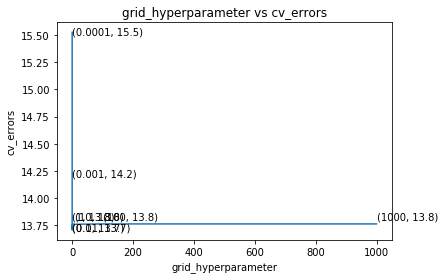

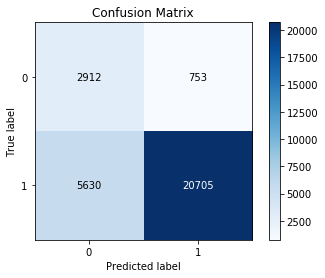

In [133]:
#train model
ww2vec_grid_model = GridSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), grid_hyperparameter, scoring = 'f1', cv=5)
ww2vec_grid_model.fit(tfidf_sent_vectors_train, y_train)

#plot cv errors
w2vec_grid_cv_errors = [(1-x[1])*100 for x in ww2vec_grid_model.grid_scores_]
plt.plot(grid_hyperparameter[0]['C'],w2vec_grid_cv_errors)
for xy in zip(grid_hyperparameter[0]['C'],np.round(w2vec_grid_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('grid_hyperparameter')
plt.ylabel('cv_errors')
plt.title('grid_hyperparameter vs cv_errors')
plt.show()

#best c value
ww2vec_grid_c = ww2vec_grid_model.best_estimator_.get_params()['C']

#f1 score
ww2vec_grid_f1_train = ww2vec_grid_model.score(tfidf_sent_vectors_train, y_train)
ww2vec_grid_f1_test = ww2vec_grid_model.score(tfidf_sent_vectors_test, y_test)

#Confusion Matrix
pred = ww2vec_grid_model.predict(tfidf_sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

# Random Search using L2 regularization

In [11]:
from numpy.random import uniform
rand_hyperparameter ={'C' : uniform(0.1,2, size=10)}
rand_hyperparameter['C'].sort()

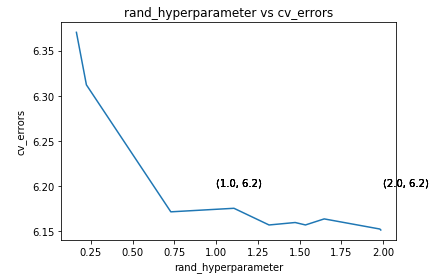

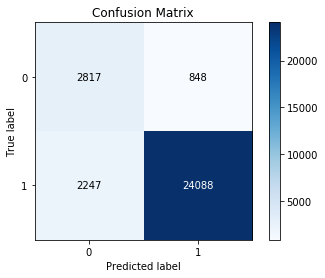

In [12]:
#train model
bow_rand_model = RandomizedSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), rand_hyperparameter, scoring = 'f1', cv=5)
bow_rand_model.fit(bag_of_words_train, y_train)

#plot cv errors
bow_rand_cv_errors = [(1-x[1])*100 for x in bow_rand_model.grid_scores_]
plt.plot(rand_hyperparameter['C'],bow_rand_cv_errors)
for xy in zip(np.round(rand_hyperparameter['C']),np.round(bow_rand_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('rand_hyperparameter')
plt.ylabel('cv_errors')
plt.title('rand_hyperparameter vs cv_errors')
plt.show()

#Best C value
bow_rand_c = bow_rand_model.best_estimator_.get_params()['C']

#f1 score
bow_rand_f1_train = bow_rand_model.score(bag_of_words_train, y_train)
bow_rand_f1_test = bow_rand_model.score(bag_of_words_test, y_test)

#predict values
pred = bow_rand_model.predict(bag_of_words_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

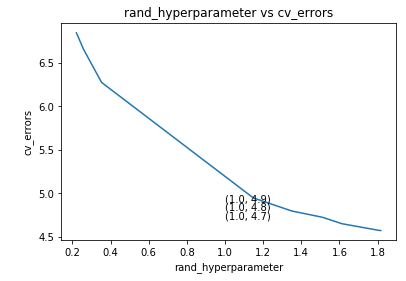

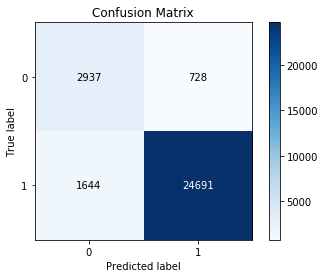

In [109]:
#train model
tfidf_rand_model = RandomizedSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), rand_hyperparameter, scoring = 'f1', cv=5)
tfidf_rand_model.fit(tf_idf_train, y_train)

#plot cv errors
tfidf_rand_cv_errors = [(1-x[1])*100 for x in tfidf_rand_model.grid_scores_]
plt.plot(rand_hyperparameter['C'],tfidf_rand_cv_errors)
for xy in zip(np.round(rand_hyperparameter['C']),np.round(tfidf_rand_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('rand_hyperparameter')
plt.ylabel('cv_errors')
plt.title('rand_hyperparameter vs cv_errors')
plt.show()

#Best c value
tfidf_rand_c = tfidf_rand_model.best_estimator_.get_params()['C']

#f1 score
tfidf_rand_f1_train = tfidf_rand_model.score(tf_idf_train, y_train)
tfidf_rand_f1_test = tfidf_rand_model.score(tf_idf_test, y_test)

#confusion matrix
pred = tfidf_rand_model.predict(tf_idf_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

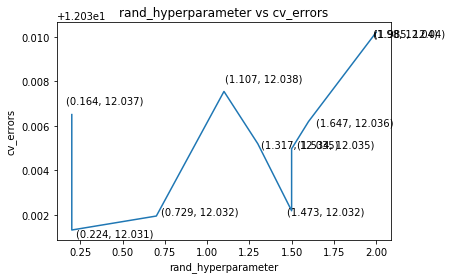

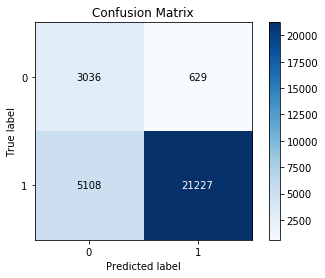

In [21]:
#train model
avgw2vec_rand_model = RandomizedSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), rand_hyperparameter, scoring = 'f1', cv=5)
avgw2vec_rand_model.fit(sent_vectors_train, y_train)

#plot cv errors
avgw2vec_rand_cv_errors = [(1-x[1])*100 for x in avgw2vec_rand_model.grid_scores_]
plt.plot(np.round(rand_hyperparameter['C'],1),avgw2vec_rand_cv_errors)
for xy in zip(np.round(rand_hyperparameter['C'],3),np.round(avgw2vec_rand_cv_errors,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('rand_hyperparameter')
plt.ylabel('cv_errors')
plt.title('rand_hyperparameter vs cv_errors')
plt.show()

#Best c value
avgw2vec_rand_c= avgw2vec_rand_model.best_estimator_.get_params()['C']

#f1-score
avgw2vec_rand_f1_train = avgw2vec_rand_model.score(sent_vectors_train, y_train)
avgw2vec_rand_f1_test = avgw2vec_rand_model.score(sent_vectors_test, y_test)

#Confusion matrix
pred = avgw2vec_rand_model.predict(sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

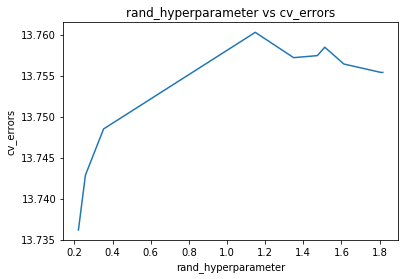

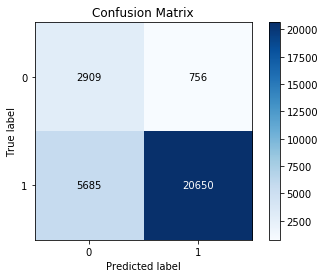

In [134]:
#train model
ww2vec_rand_model = RandomizedSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), rand_hyperparameter, scoring = 'f1', cv=5)
ww2vec_rand_model.fit(tfidf_sent_vectors_train, y_train)

#plot cv errors
w2vec_rand_cv_errors = [(1-x[1])*100 for x in ww2vec_rand_model.grid_scores_]
plt.plot(rand_hyperparameter['C'],w2vec_rand_cv_errors)
for xy in zip(np.round(rand_hyperparameter['C'],1),np.round(w2vec_rand_cv_errors,1)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('rand_hyperparameter')
plt.ylabel('cv_errors')
plt.title('rand_hyperparameter vs cv_errors')
plt.show()

#best c value
ww2vec_rand_c = ww2vec_rand_model.best_estimator_.get_params()['C']

#f1 score
ww2vec_rand_f1_train = ww2vec_rand_model.score(tfidf_sent_vectors_train, y_train)
ww2vec_rand_f1_test = ww2vec_rand_model.score(tfidf_sent_vectors_test, y_test)

#Confusion Matrix
pred = ww2vec_rand_model.predict(tfidf_sent_vectors_test)
skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=False)

In [135]:
from prettytable import PrettyTable
    
Table = PrettyTable()

Table.field_names  = ["Model", "Hyper_parameter(C)", "Train f1-score", "Test f1-score"]

Table.add_row(["grid_BOW", bow_grid_c, bow_grid_f1_train,bow_grid_f1_test])
Table.add_row(["grid_TF_IDF", tfidf_grid_c,tfidf_grid_f1_train, tfidf_grid_f1_test])
Table.add_row(["grid_avgw2vec", avgw2vec_grid_c, avgw2vec_grid_f1_train,avgw2vec_grid_f1_test])
Table.add_row(["grid_ww2vec", ww2vec_grid_c, ww2vec_grid_f1_train,ww2vec_grid_f1_test])
Table.add_row(["rand_BOW", bow_rand_c, bow_rand_f1_train,bow_rand_f1_test])
Table.add_row(["rand_TF_IDF", tfidf_rand_c, tfidf_rand_f1_train,tfidf_rand_f1_test])
Table.add_row(["rand_avgw2vec", avgw2vec_rand_c, avgw2vec_rand_f1_train,avgw2vec_rand_f1_test])
Table.add_row(["rand_ww2vec", ww2vec_rand_c, ww2vec_rand_f1_train,ww2vec_rand_f1_test])

print(Table)

+---------------+---------------------+--------------------+--------------------+
|     Model     |  Hyper_parameter(C) |   Train f1-score   |   Test f1-score    |
+---------------+---------------------+--------------------+--------------------+
|    grid_BOW   |          1          | 0.9642443665162167 | 0.9396309039724742 |
|  grid_TF_IDF  |         1000        | 0.9999918558153551 | 0.9653080068592534 |
| grid_avgw2vec |         0.1         | 0.8805440673131775 | 0.8805164611616225 |
|  grid_ww2vec  |         0.01        | 0.8627956446495529 | 0.8664448768648129 |
|    rand_BOW   |  1.349544480197799  | 0.9667247211709147 | 0.9395797531635681 |
|  rand_TF_IDF  |  1.816945741505411  | 0.9818932155494601 | 0.9541677937937165 |
| rand_avgw2vec |  0.257604623640196  | 0.8803481300494016 | 0.8804916535171498 |
|  rand_ww2vec  | 0.22082248356008288 | 0.8625781369798761 | 0.8650845185479985 |
+---------------+---------------------+--------------------+--------------------+


# Error and  sparsity using L1 Regularization 

In [136]:
from sklearn.metrics import confusion_matrix
lambdas = [0.0001,0.001,0.01,0.1,1,10]
sparsities = []
error = []
for lambd in lambdas:
    C = (1/lambd)
    clf = LogisticRegression(C=C, penalty='l1',class_weight = 'balanced');
    clf.fit(tf_idf_train, y_train);
    w = clf.coef_
    sparsity = np.count_nonzero(w)
    sparsities.append(sparsity)
    pred = clf.predict(tf_idf_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    pr,re = (tp)/(tp+fp),(tp)/(tp+fn)
    f1_score_tfidf_ww_test = (2*pr*re)/(pr+re)
    error.append((1-f1_score_tfidf_ww_test)*100)

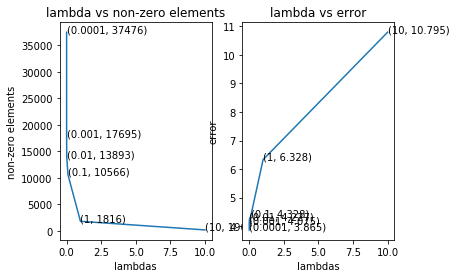

In [137]:
fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(lambdas,sparsities)
for xy in zip(lambdas,sparsities):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('lambdas')
plt.ylabel('non-zero elements')
plt.title('lambda vs non-zero elements')

plt.subplot(1,2,2)
plt.plot(lambdas,error)
for xy in zip(lambdas,np.round(error,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('lambdas')
plt.ylabel('error')
plt.title('lambda vs error')
plt.show()

# Pertubation Test

In [8]:
from sklearn.preprocessing import StandardScaler

#Standardize train data
Standardized_data_train = StandardScaler(with_mean=False).fit(tf_idf_train)
standard_tf_idf_train = Standardized_data_train.transform(tf_idf_train)

#train model to find weight vector
clf_before = LogisticRegression(C=1000,penalty='l2',class_weight = 'balanced');
clf_before.fit(standard_tf_idf_train, y_train);
w_before_ptrb = clf_before.coef_

#add noise
noise = 0.1
standard_tf_idf_train_prtb = csr_matrix(standard_tf_idf_train)
standard_tf_idf_train_prtb.data = standard_tf_idf_train_prtb.data + noise

#train model using pertubated data to find weight vector
clf_after = LogisticRegression(C=1000, penalty='l2',class_weight = 'balanced');
clf_after.fit(standard_tf_idf_train_prtb, y_train);
w_after_prtb = clf_after.coef_

In [15]:
delta = abs(w_before_ptrb - w_after_prtb)+100
denom = w_before_ptrb+100

diff_weights = delta/denom
percent_change = diff_weights*100
percent_change

array([[100.00039017,  99.99836499, 100.00363008, ...,  99.9990006 ,
         99.9990006 ,  99.99890121]])

In [32]:
threshold = [10,20,30,40,50,60,70,80,90,100]
number_of_features = []
for x in threshold:
    feat = len(percent_change[percent_change >= x])
    number_of_features.append(feat)

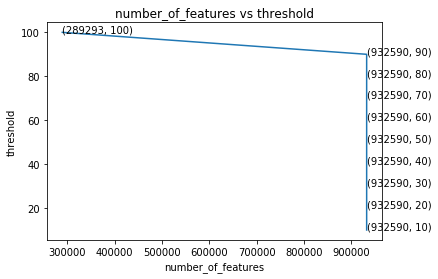

In [33]:
plt.plot(number_of_features,threshold)
for xy in zip(number_of_features,threshold):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('number_of_features')
plt.ylabel('threshold')
plt.title('number_of_features vs threshold')
plt.show()

# Feature Importance

In [39]:
#using weight vector to find important feature
indx = w_before_ptrb.argsort()
neg_indxs = indx[0,:100]
pos_indxs = indx[0,(w_before_ptrb.shape[1]-100):(w_before_ptrb.shape[1]-1)]

In [40]:
feature_importance_neg = [np.take(tf_idf_vect.get_feature_names(),neg_indx)  for neg_indx in neg_indxs]
feature_importance_pos = [np.take(tf_idf_vect.get_feature_names(),pos_indx)  for pos_indx in pos_indxs]

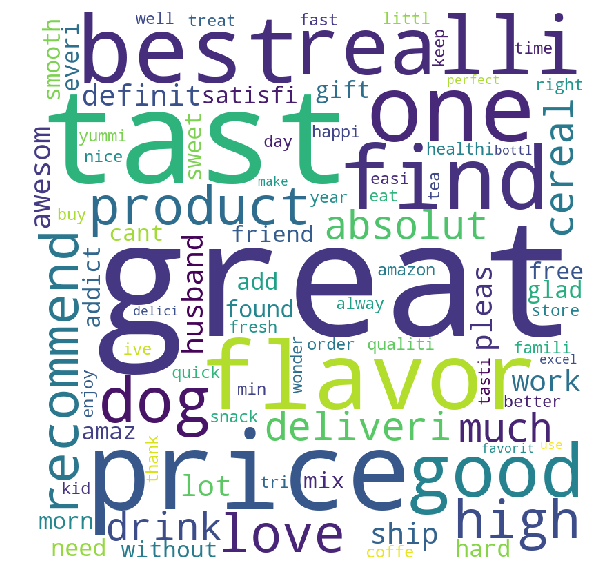

In [41]:
from wordcloud import WordCloud

featurez=(" ").join(feature_importance_pos)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(featurez) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

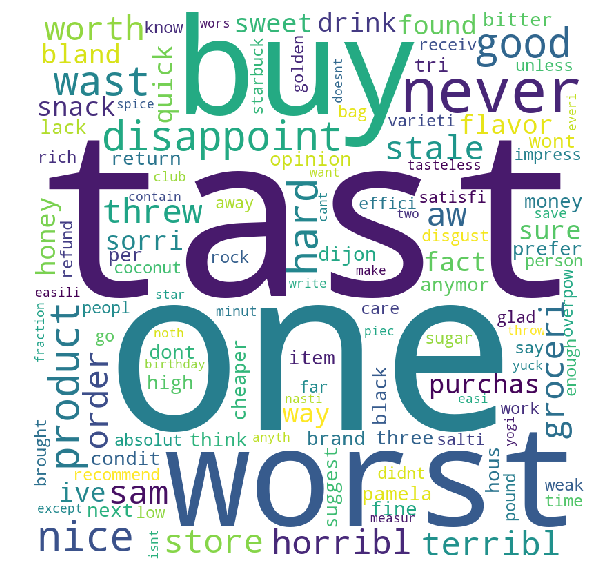

In [42]:
from wordcloud import WordCloud

featurez=(" ").join(feature_importance_neg)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10).generate(featurez) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 